# **Modelo con Logistic Regression**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## **Descarga del Dataset original**

Para descargar el dataset a Colab, es necesario subir su Kaggle API Key personal (para crear una nueva, revise la sección Authentication en https://www.kaggle.com/docs/api).

Suba a continuación el archivo `.json` generado.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniellujanagudelo","key":"e0f7fc0287fd836756e720097ec0469f"}'}

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

 99% 681M/688M [00:08<00:00, 82.8MB/s]
100% 688M/688M [00:08<00:00, 85.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/home-credit-default-risk.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

## **Preprocesamiento**

La siguiente función realiza todo el preprocesamiento necesario a los datos, explicado en [01 - Preprocesamiento.ipynb](https://colab.research.google.com/drive/1w9a0auNVqZ2hN_urrf3rmJ-3gVfDUBx0#scrollTo=2c5ymp78xowc)

In [ ]:
def preprocess_data(data: pd.DataFrame, test_data: pd.DataFrame):
    def fill_nan_with_mode(column):
        mode = column.mode()[0]
        return column.fillna(mode)
    data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
    test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)
    cat_columns = data.select_dtypes(include=["object"])
    data_encoded = pd.get_dummies(data, columns=cat_columns.columns)
    test_data_encoded = pd.get_dummies(test_data, columns=cat_columns.columns)

    return data_encoded, test_data_encoded

data, test_data = preprocess_data(pd.read_csv("/content/application_train.csv"), pd.read_csv("/content/application_test.csv"))

<ipython-input-7-c319868e6578>:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = data.fillna(data.mean()).apply(fill_nan_with_mode, axis=0)
<ipython-input-7-c319868e6578>:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_data = test_data.fillna(test_data.mean()).apply(fill_nan_with_mode, axis=0)


## **Predicción con parámetros por defectos**

In [ ]:
X_train = data.drop("TARGET", axis=1)
y_train = data["TARGET"]
for col in X_train.columns.difference(test_data.columns):
    test_data[col] = [0] * len(test_data)

test_data = test_data[X_train.columns]

In [ ]:
model = LogisticRegression()

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = model.predict_proba(test_data)

In [ ]:
df = pd.DataFrame()
df["SK_ID_CURR"] = test_data["SK_ID_CURR"]
df["TARGET"] = y_pred[:, 1]
df = df.set_index("SK_ID_CURR")
df.to_csv("results.csv")

Se obtuvo un puntaje `~61.84%`

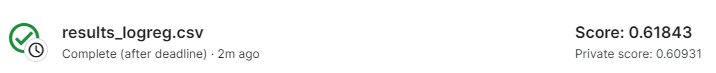

## **Búsqueda de mejores hiperparámetros**

In [ ]:
model = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0],
    'penalty': ['l1', 'l2', 'elasticnet']
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

{'C': 0.1, 'penalty': 'l2'}

Por lo tanto, los mejores hiperparámetros (de los probados) para este modelo son `C = 0.1` y `penalty = "l2"`

## **Resultados con los mejores hiperparámetros**

In [ ]:
model = LogisticRegression(C=grid_search.best_params_["C"], penalty=grid_search.best_params_["penalty"])

model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [ ]:
y_pred = model.predict_proba(test_data)

In [ ]:
df = pd.DataFrame()
df["SK_ID_CURR"] = test_data["SK_ID_CURR"]
df["TARGET"] = y_pred[:, 1]
df = df.set_index("SK_ID_CURR")
df

,TARGET
SK_ID_CURR,
100001,0.096774
100005,0.102988
100013,0.062967
100028,0.030570
100038,0.075737
...,...
456221,0.058587
456222,0.130008
456223,0.077000


In [ ]:
df.to_csv("results.csv")

A pesar de realizar la predicción con los mejores parámetros hayados, el puntaje obtenido no fue mejor

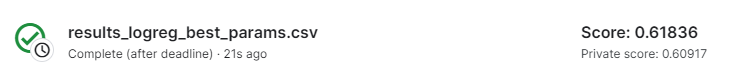

## **Curva de aprendizaje**

In [ ]:
model = LogisticRegression(C=grid_search.best_params_["C"], penalty=grid_search.best_params_["penalty"])
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Generate learning curves
res = learning_curve(
    model, X_train, y_train, cv=cv, n_jobs=-1, train_sizes=[0.1, 0.35, 0.6, 1.0]
)

In [ ]:
train_sizes = res[0]
train_scores = res[1]
test_scores = res[2]

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

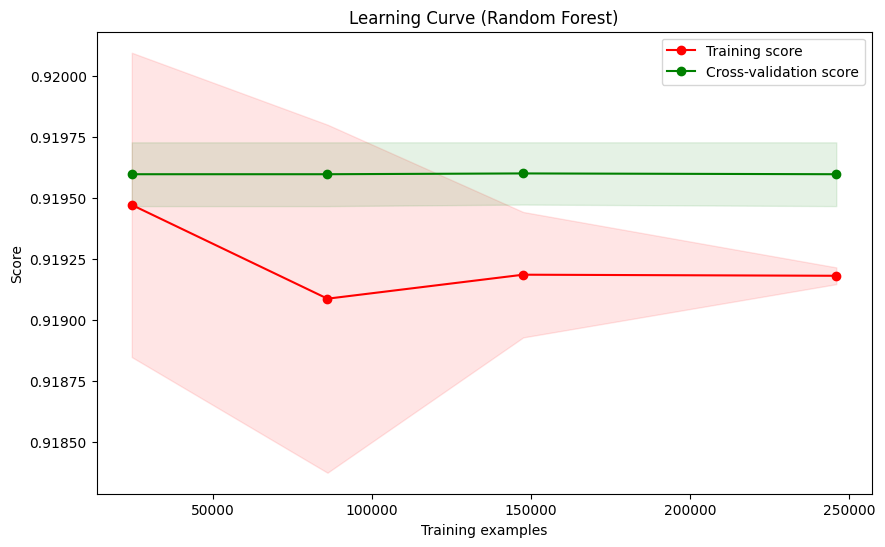

In [ ]:
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve (Logistic Regression)")
plt.show()